<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/ivan-private_lab1/Lab1/ivan-private_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Ivan Zivkovic**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [21]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [22]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v)
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q)
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$.

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero.

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces,
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition.

We will also implement equal order interpolation of the velocity and pressure and show that the velocity is stable but the pressure solution is unstable. Furthermore, we will implement Brezzi-Pitkäranta stabilization and show that equal order interpolation is then stable. Brezzi-Pitkäranta stabilization involves adding a extra stabilization term $s(P, q)$ to the pressure field which takes the form

$$s(P, q) = C \int_{\Omega}h^2 \nabla P \cdot \nabla q \; dx = Ch^2(\nabla P, \nabla q)$$

with $C > 0$.

With the addition of this stabilization term the new residual form equation becomes

$$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v) + Ch^2(\nabla P, \nabla q)$$

# **Method**

**Define domain and mesh**

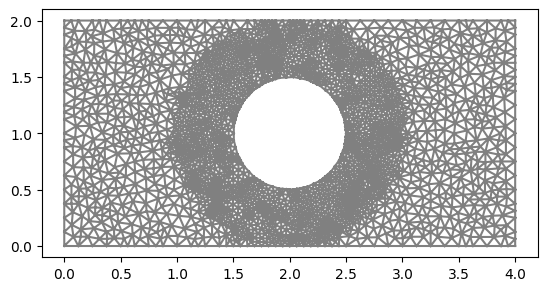

In [23]:
# Define rectangular domain
L = 4
H = 2

# Generate mesh
resolution = 32
mesh = generate_mesh(
    Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L, 0.5*H), 0.5),
    resolution
)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0, no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):

        cell_marker[cell] = False
        p = cell.midpoint()
        if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
            cell_marker[cell] = True

    mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [24]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2) #second order polynomial
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

# Generate equal order finite element spaces (for velocity and pressure)
VE_linear = VectorElement("CG", mesh.ufl_cell(), 1) #linear
WE_linear = VE_linear * QE


W = FunctionSpace(mesh, WE)
W_linear = FunctionSpace(mesh, WE_linear)

V = FunctionSpace(mesh, VE)
V_linear = FunctionSpace(mesh, VE_linear)

Q = FunctionSpace(mesh, QE)



# Define trial and test functions for mixed
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)


# Define trial and test functions for linear
w_linear = Function(W_linear)
(u_linear, p_linear) = ( as_vector( (w_linear[0], w_linear[1]) ), w_linear[2] )
(v_linear, q_linear) = TestFunctions(W_linear)

**Define boundary conditions**

In [25]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
uin_linear = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V_linear.ufl_element())

#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

##

**Define the constants for this simulation**

The constant $\alpha$ is the constant for the Brezzi-Pitkäranta stabilization term where $\alpha = Ch^2$ with $C=1$.

In [26]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h
alpha = 1.0 * h * h

## **Define and solve variational problem for Taylor-Hood mixed element**

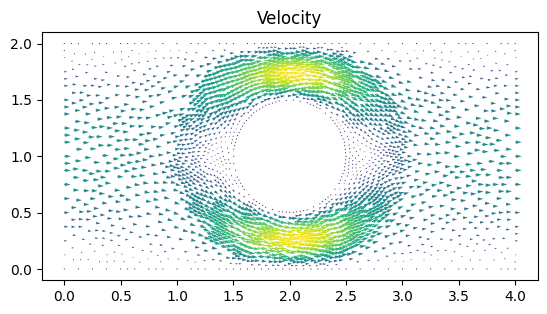

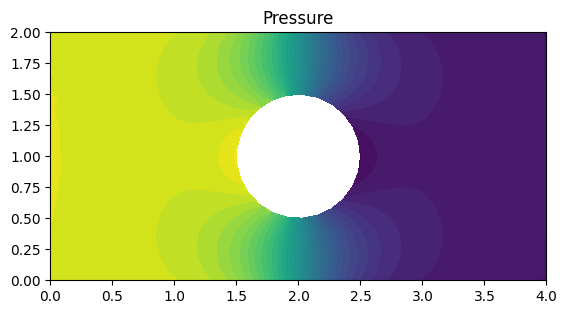

In [27]:
f = Expression(("0.0","0.0"), element=V.ufl_element())


# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p * div(v) * dx
             + inner(grad(u), grad(v)) * dx
             + div(u) * q * dx
             + gamma * (ib * inner(u - uin, v) + wb * inner(u, v)) * ds
             - inner(f, v) * dx
             )


# Solve algebraic system
solve(residual == 0, w)

u1 = project(u, V)
p1 = project(p, Q)


# Plot solution
plt.figure()
plot(u1, title="Velocity")

plt.figure()
plot(p1, title="Pressure")

plt.show()


The result of the Taylor-Hood mixed element simulation shows a velocity field and pressure field that is looking reasonable and well behaved as expected.


## **Define and solve variational problem for equal order interpolation of the velocity and pressure**

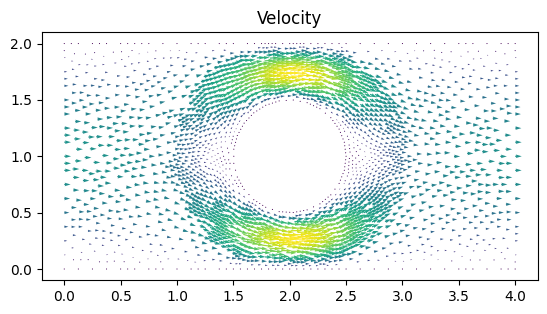

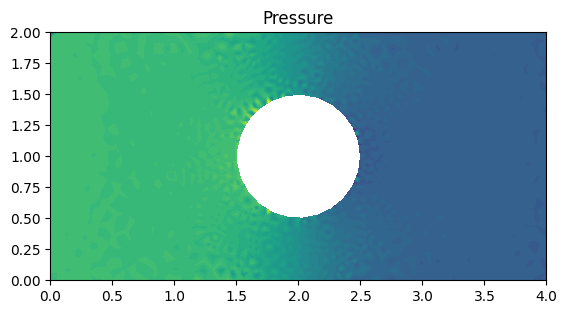

In [28]:
f_linear = Expression(("0.0","0.0"), element=V_linear.ufl_element())

residual_linear = ( - p_linear * div(v_linear) * dx
                    + inner(grad(u_linear), grad(v_linear)) * dx
                    + div(u_linear) * q_linear * dx
                    + gamma * ( ib * inner(u_linear - uin_linear, v_linear) + wb * inner(u_linear, v_linear) ) * ds
                    - inner(f_linear, v_linear) * dx
                    )


# Solve algebraic system
solve(residual_linear == 0, w_linear)

u2 = project(u_linear, V_linear)
p2 = project(p_linear, Q)


# Plot solution
plt.figure()
plot(u2, title="Velocity")

plt.figure()
plot(p2, title="Pressure")

plt.show()


The result of the equal order interpolation shows the same solution for the velocity field as the Taylor-Hood mixed element implementation, but the pressure field is clearly unstable where we can se many sudden jumps in the pressure almost everywhere in the plot.  

## **Define and solve variational problem for equal order interpolation of the velocity and pressure, with Brezzi-Pitkäranta stabilizaiton**

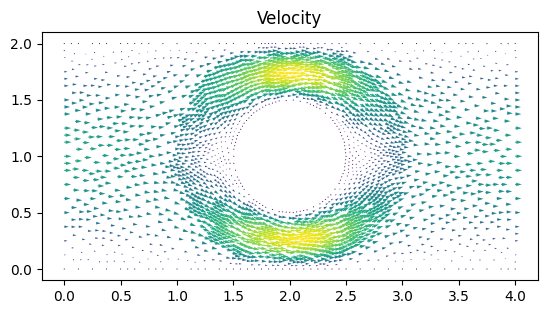

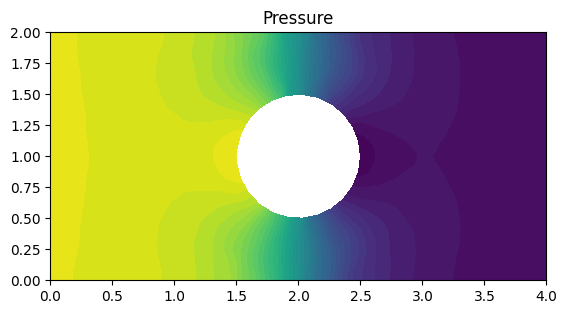

In [29]:
f_linear = Expression(("0.0","0.0"), element=V_linear.ufl_element())

# alpha*inner(grad(p), grad(q))*dx is the term for the
# Brezzi-Pitkäranta stabilization
BP_residual_linear = ( - p_linear * div(v_linear) * dx
                    + inner(grad(u_linear), grad(v_linear)) * dx
                    + div(u_linear) * q_linear * dx
                    + alpha * inner(grad(p_linear), grad(q_linear)) * dx
                    + gamma * ( ib * inner(u_linear - uin_linear, v_linear) + wb * inner(u_linear, v_linear) ) * ds
                    - inner(f_linear, v_linear) * dx
                    )


# Solve algebraic system
solve(BP_residual_linear == 0, w_linear)

u3 = project(u_linear, V_linear)
p3 = project(p_linear, Q)


# Plot solution
plt.figure()
plot(u3, title="Velocity")

plt.figure()
plot(p3, title="Pressure")

plt.show()


The results show the same velocity and pressure field as for the results from the Taylor-Hood implementation even though equal (linear) order interpolation was used for both the velocity and pressure showing that the Brezzi-Pitkäranta stabilization works as expected.

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  